In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import glob

# Set global settings

In [2]:
fft = np.fft.fftn
ifft = np.fft.ifftn
xwidth, ywidth, twidth = 12, 12, 12

# Use real data

Make a large image cube with all the data preloaded into it for easy access and usage in beta noise modeling. 

In [ ]:
glo

In [13]:
fns = glob.glob("/Volumes/Herschel/data/june_fits/94/*")
data = np.zeros((1280, 1280, len(fns)))
for i, fn in enumerate(fns):
    image_file = fits.open(fn)
    img = image_file[0].data.copy()
    img[np.isnan(img)] = 0
    img[np.isinf(img)] = 0
    img[img < 0] = 0
    data[:,:,i] = img
    # uncomment below to add even more noise!
    #data[:,:,i] = (img + np.random.poisson(img))
    image_file.close()

In [14]:
data.shape

(1280, 1280, 95)

# Take a look at the image

<IPython.core.display.Javascript object>


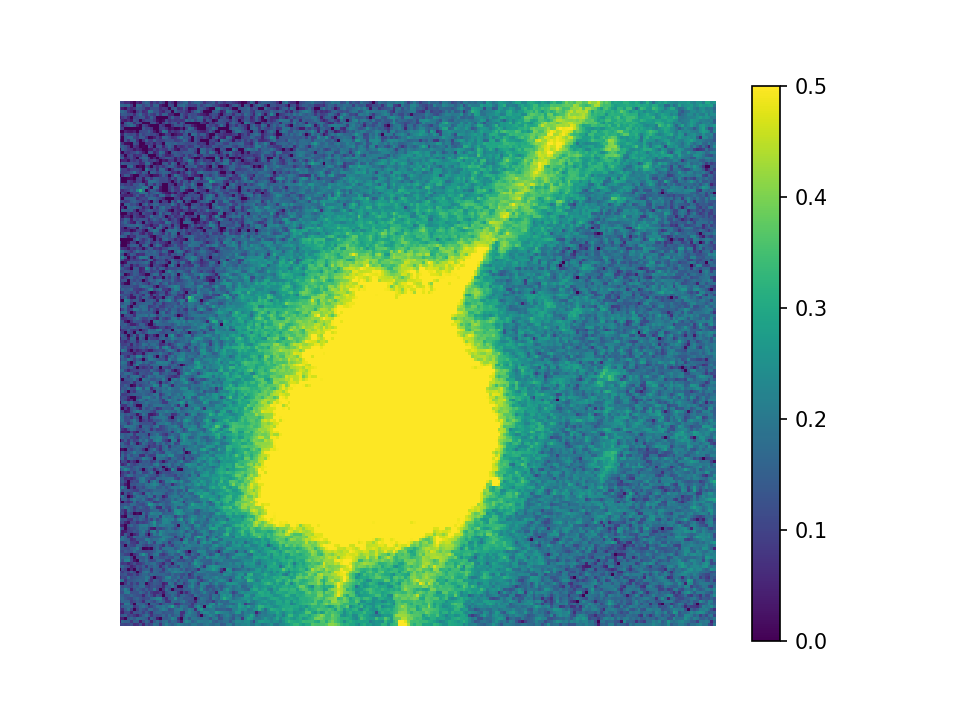

In [17]:
plt.figure()#figsize=(15,15))
plt.imshow(np.sqrt(data[:,:,5]), origin='lower', interpolation='None', vmax=0.5)
plt.colorbar()
plt.axis("off")
plt.show()

In [5]:
data.nbytes / 10**9

1.245184

# Define all image section coordinates

In [18]:
# define grid
#xstart, xend, xstep  = 600, 800, 3
xstart, xend, xstep = xwidth*2, data.shape[0] - (xwidth*2), 3

#ystart, yend, ystep = 600, 800, 3
ystart, yend, ystep = ywidth*2, data.shape[1] - (ywidth*2), 3

#tstart, tend, tstep = 50, 56, 3
tstart, tend, tstep = twidth, data.shape[2] - twidth, 3

x_ = np.arange(xstart, xend, xstep)
y_ = np.arange(ystart, yend, ystep)
t_ = np.arange(tstart, tend, tstep)
coords = []
for t in t_:
    for y in y_:
        for x in x_:
            coords.append((x,y,t))

In [32]:
# define grid
xstart, xend, xstep  = 600, 800, 3
#xstart, xend, xstep = xwidth*2, data.shape[0] - (xwidth*2), 3

ystart, yend, ystep = 600, 800, 3
#ystart, yend, ystep = ywidth*2, data.shape[1] - (ywidth*2), 3

tstart, tend, tstep = twidth, data.shape[2] - twidth, 3
#tstart, tend, tstep = twidth, data.shape[2] - twidth, 3

x_ = np.arange(xstart, xend, xstep)
y_ = np.arange(ystart, yend, ystep)
t_ = np.arange(tstart, tend, tstep)
coords = []
for t in t_:
    for y in y_:
        for x in x_:
            coords.append((x,y,t))

In [33]:
len(coords)

368098

#  Define hanning window

In [19]:
#NX, NY, NT = 2*xwidth+1, 2*ywidth+1, 2*twidth+1
NX, NY, NT = xwidth, ywidth, twidth
hanning_window_3D = lambda x, y, t : (np.power(np.sin((x + 0.5)*np.pi / NX), 2.0) * 
                                       np.power(np.sin((y + 0.5) * np.pi / NY), 2.0) * 
                                       np.power(np.sin((t + 0.5) * np.pi / NT), 2.0))

hanning = np.zeros((NX, NY, NT))
for x in range(hanning.shape[0]):
    for y in range(hanning.shape[1]):
        for t in range(hanning.shape[2]):
            hanning[x,y,t] = hanning_window_3D(x,y,t)

<IPython.core.display.Javascript object>


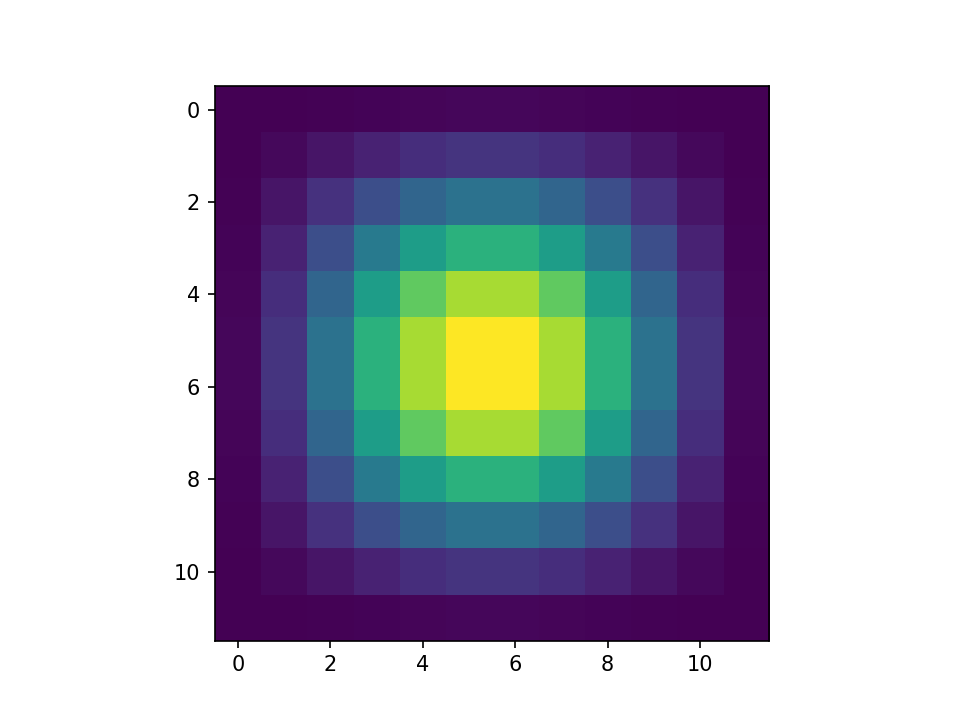

In [20]:
plt.figure()#figsize=(15,15))
plt.imshow(hanning[:,:,0])
plt.show()

# Determine beta

In [21]:
beta_stack = []
for i in np.random.choice(len(coords),10000):
    x, y, t = coords[i]
    #image_section = data[x-xwidth : x+xwidth + 1,
    #                     y-ywidth : y+ywidth + 1, 
    #                     t-twidth : t+twidth+1].copy()
    image_section = data[x-xwidth//2 : x+xwidth//2, 
                         y-ywidth//2 : y+ywidth//2, 
                         t-twidth//2 : t+twidth//2].copy()
    image_section *= hanning
    imbar = np.sum(np.sqrt(image_section))
    beta_fourier = np.fft.fftshift(fft(image_section))
    #beta_fourier_magnitude = np.log(np.power(np.abs(beta_fourier), 2.0))
    beta_fourier_magnitude = np.abs(beta_fourier)
    beta_stack.append(beta_fourier_magnitude / imbar)

beta_approx = np.median(np.stack(beta_stack), axis=0)

Instead of using median, you can also use some other defined percentile as below. 

In [10]:
#percentile = 40
#beta_approx = np.percentile(np.stack(beta_stack), percentile, axis=0)

In [11]:
beta_approx.shape

(12, 12, 12)

<IPython.core.display.Javascript object>


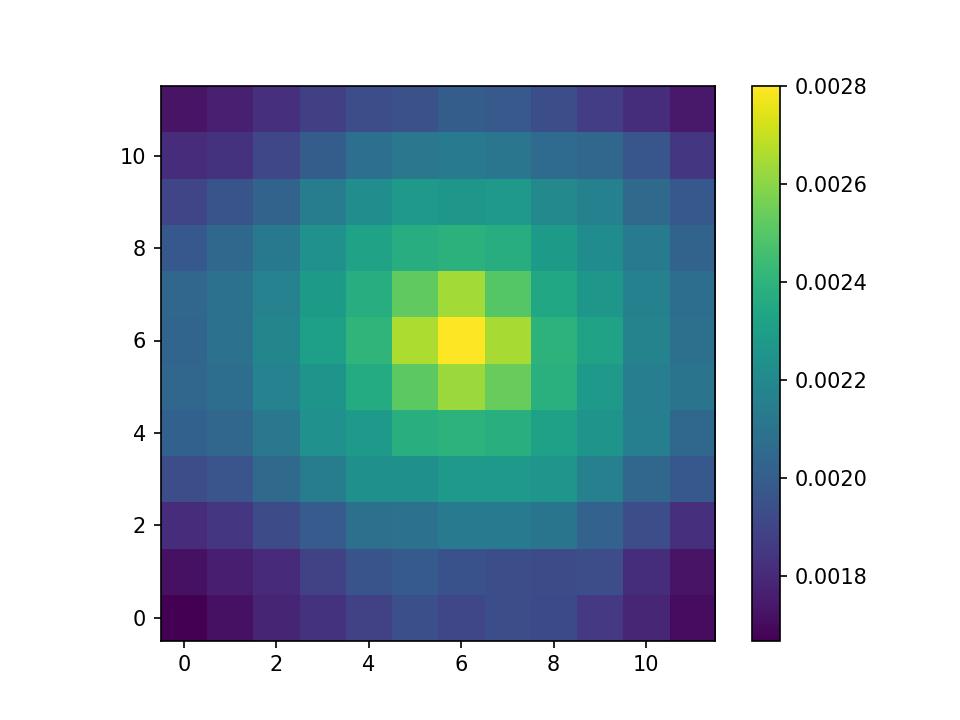

In [22]:
plt.figure()
plt.imshow(beta_approx[:,:,1], origin='lower', interpolation='None')
plt.colorbar()
plt.show()

In [29]:
del beta_stack

# Do for the full image

In [23]:
import time
gated_image = np.zeros_like(data)
times = []
for i in range(len(coords)):
    start = time.time()
    x, y, t = coords[i]

    image_section = data[x-xwidth//2 : x+xwidth//2, 
                         y-ywidth//2 : y+ywidth//2, 
                         t-twidth//2 : t+twidth//2].copy()

    image_section *= hanning
    imbar = np.sum(np.sqrt(image_section))

    fourier = np.fft.fftshift(fft(image_section))
    fourier_magnitude = np.abs(fourier)
    
    noise = beta_approx * imbar
    threshold = noise * 3.0
    
    gate_filter = np.logical_not(fourier_magnitude < threshold)
    #wiener_filter =  (fourier_magnitude / threshold) / (1 + (fourier_magnitude / threshold))

    gate_filter[5:8, 5:8, 5:8] = True

    #final_fourier = fourier * wiener_filter
    final_fourier = fourier * gate_filter
    
    final_image = hanning * np.abs(ifft(np.fft.ifftshift(final_fourier)))

    gated_image[x-xwidth//2 : x+xwidth//2,
                y-ywidth//2 : y+ywidth//2, 
                t-twidth//2 : t+twidth//2] += final_image
    
    times.append(time.time() - start)

<IPython.core.display.Javascript object>


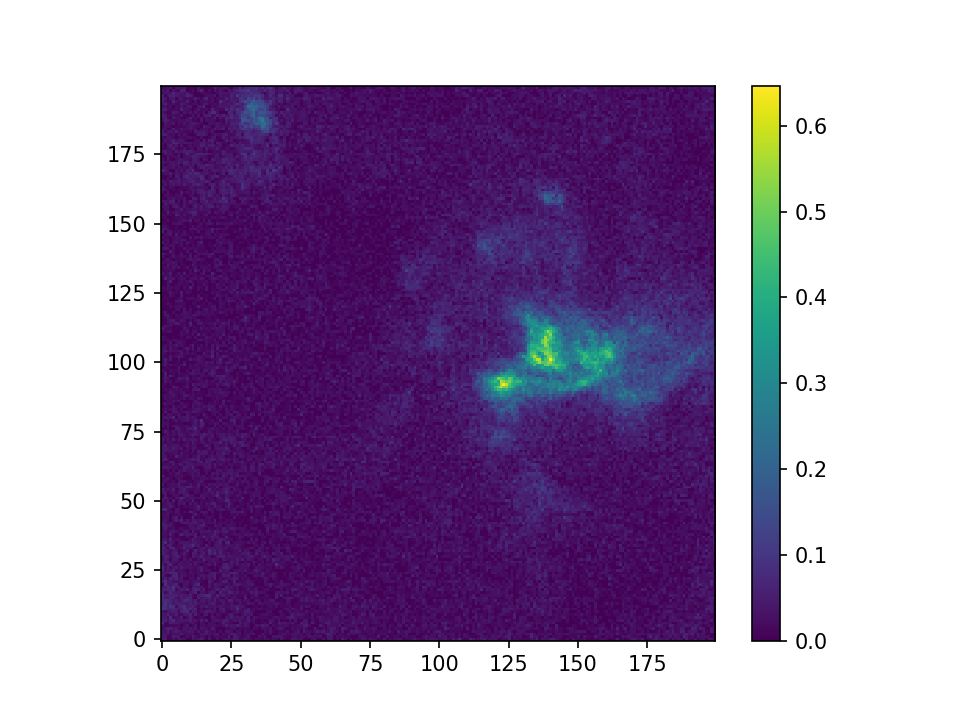

In [24]:
plt.figure()#figsize=(10,10))
plt.imshow(data[600:800,600:800,40], origin='lower', interpolation='None')
#plt.imshow(data[:,:,50])
plt.colorbar()
plt.show()

In [31]:
dir(axes[0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autoscaleXon',
 '_autoscaleYon',
 '_axes',
 '_axes_class',
 '_axes_locator',
 '_axisbelow',
 '_cachedRenderer',
 '_clipon',
 '_clippath',
 '_connected',
 '_contains',
 '_current_image',
 '_cursorProps',
 '_facecolor',
 '_frameon',
 '_gci',
 '_gen_axes_patch',
 '_gen_axes_spines',
 '_get_axis_list',
 '_get_legend_handles',
 '_get_lines',
 '_get_patches_for_fill',
 '_get_view',
 '_gid',
 '_gridOn',
 '_hold',
 '_init_axis',
 '_label',
 '_left_title',
 '_make_twin_axes',
 '_mouseover',
 '_navigate',
 '_navigate_mode',


In [40]:
fns[40]

'/Volumes/Herschel/data/june_fits/94/suvi_94_20170610_000248.fits'

In [41]:
img = fits.open(fns[40])
img[0].data = gated_image[:,:,40]
img.writeto("/Users/mhughes/Desktop/suvi_94_20170610_000248_gated.fits")

In [42]:
img = fits.open(fns[40])
#img[0].data = gated_image[:,:,40]
img.writeto("/Users/mhughes/Desktop/suvi_94_20170610_000248_dirty.fits")

In [45]:
fns[0].split(".fits")[0] + "_cleaned.fits"

'/Volumes/Herschel/data/june_fits/94/suvi_94_20170601_000219_cleaned.fits'

In [46]:
for i in range(len(fns)):
    with fits.open(fns[i]) as img:
        img[0].data = gated_image[:,:,i]
        img.writeto(fns[i].split(".fits")[0] + "_cleaned.fits")

<IPython.core.display.Javascript object>


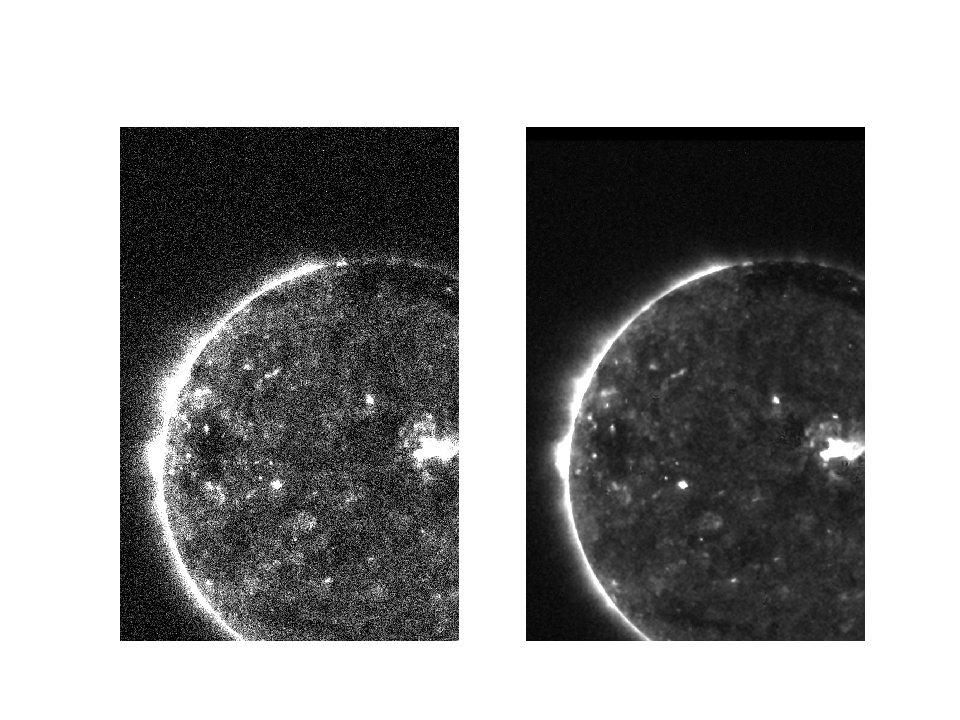

In [38]:
fig, axes = plt.subplots(1,2, sharex=True, sharey=True)
axes[0].imshow(data[:,:,40], origin="lower", interpolation="None", cmap='gray', vmax=0.1)
axes[0].set_axis_off()
axes[1].imshow(gated_image[:,:,40], origin='lower', interpolation='None',cmap="gray", vmax=0.5)
axes[1].set_axis_off()
#plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


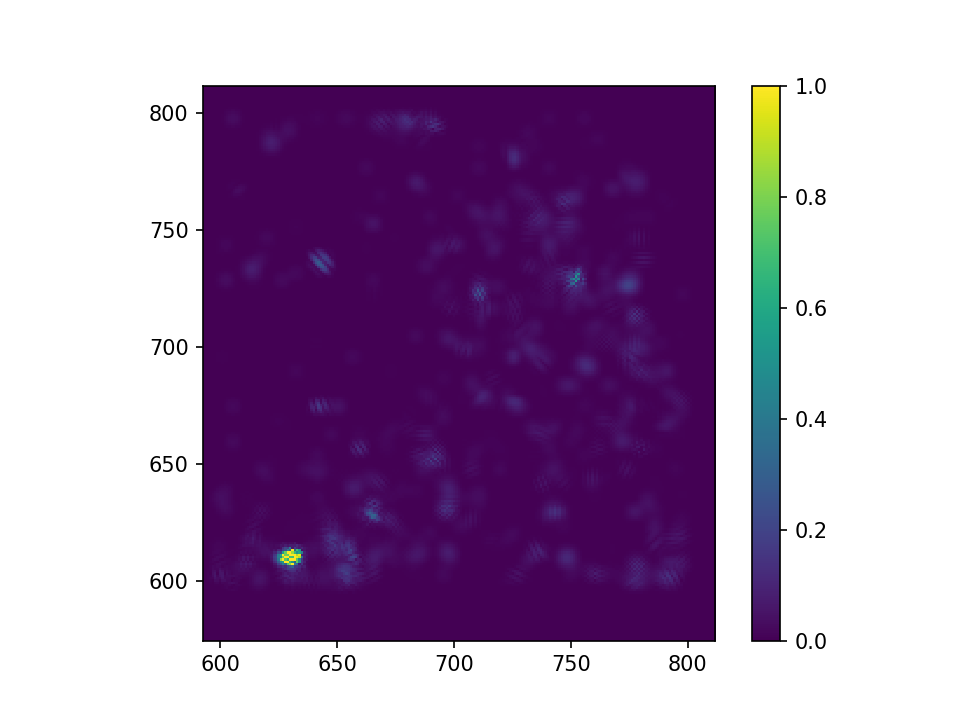

In [44]:
plt.figure()#figsize=(10,10))
plt.imshow(gated_image[:,:,49], origin='lower', interpolation='None', vmax=1)
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


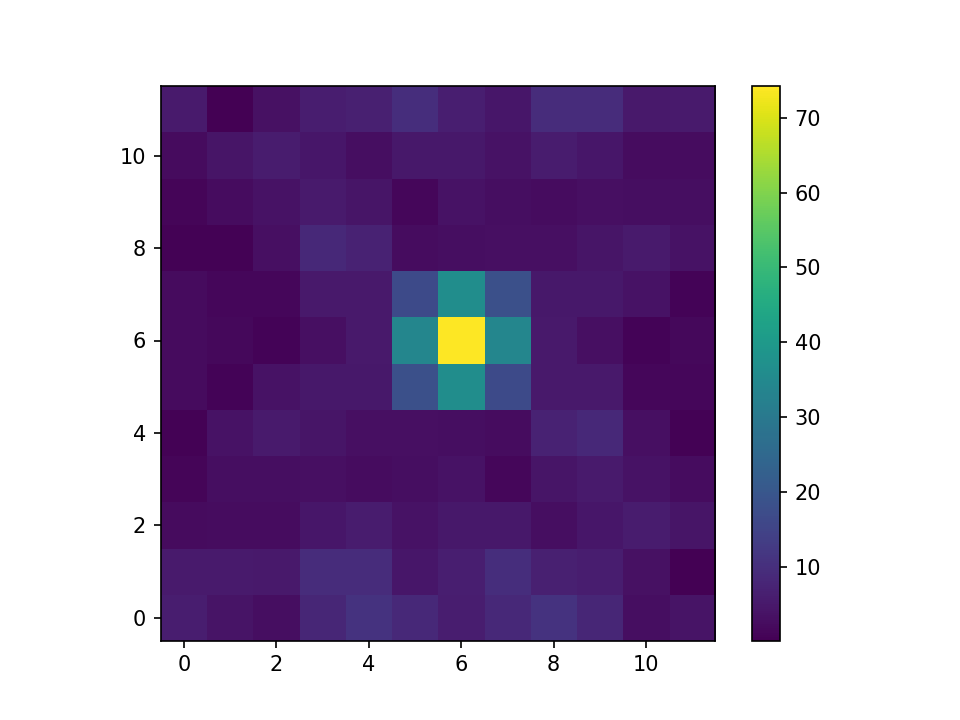

In [54]:
plt.figure()#figsize=(10,10))
plt.imshow(fourier_magnitude[:,:,6], origin='lower', interpolation='None')
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


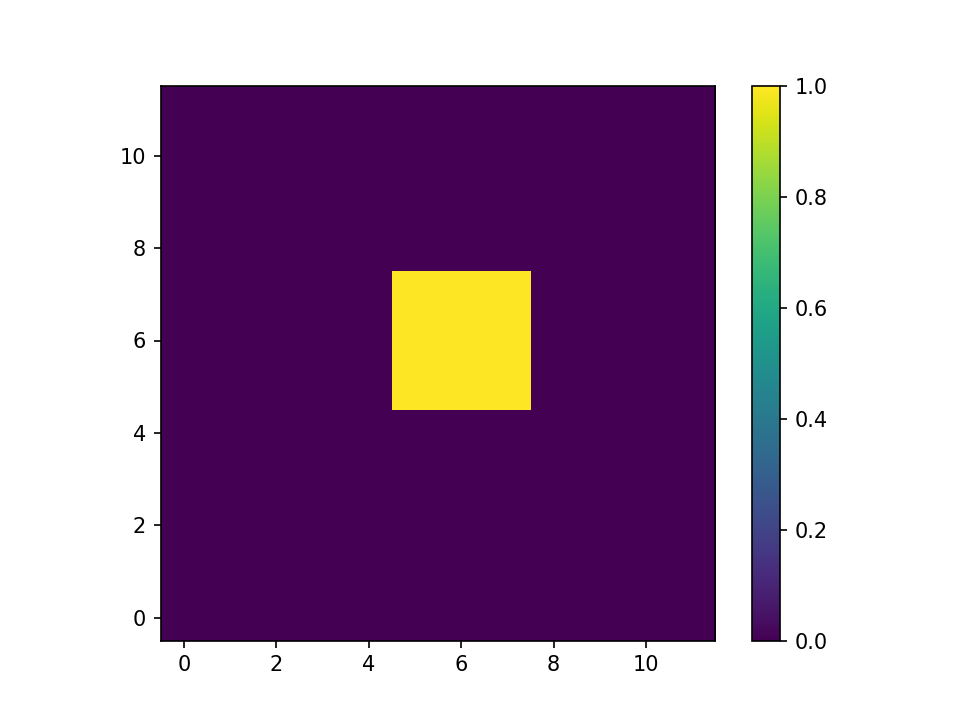

In [55]:
plt.figure()#figsize=(10,10))
plt.imshow(gate_filter[:,:,6], origin='lower', interpolation='None')
plt.colorbar()
plt.show()

In [50]:
gate_filter[5:8, 5:8, :] = True

In [62]:
xwidth // 2 - 1 , xwidth // 2 + 2

(5, 8)

In [36]:
np.median(times)

0.00030088424682617188

In [37]:
len(coords) * np.median(times)

110.75488948822021

In [30]:
gate_filter.shape

(12, 12, 12)

In [ ]:
gate_filter[:,:,]

In [180]:
np.median(times) * 180000

123.66056442260742

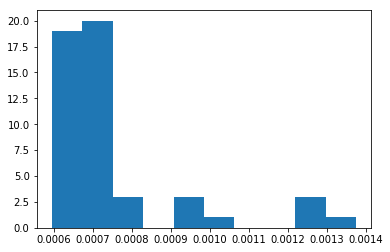

In [154]:
plt.hist(times)
plt.show()

In [19]:
f = fits.open("/Volumes/Herschel/proc_fits/171/SUVI_171_20170418_180253.fits")

In [23]:
fns[40]

'/Volumes/Herschel/proc_fits/171/SUVI_171_20170418_204253.fits'

In [24]:
f[0].data = data[:,:,40]
f.writeto("/Users/mhughes/Desktop/SUVI_171_20170418_204253_messy.fits")

In [28]:
f[0].data = gated_image[:,:,40]
f.writeto("/Users/mhughes/Desktop/SUVI_171_20170418_204253_cleaned_wiener.fits")

In [51]:
%matplotlib notebook

In [56]:
np.sum(times)

4677.54416680336

In [61]:
np.sum(times) / data.shape[2]

25.98635648224089

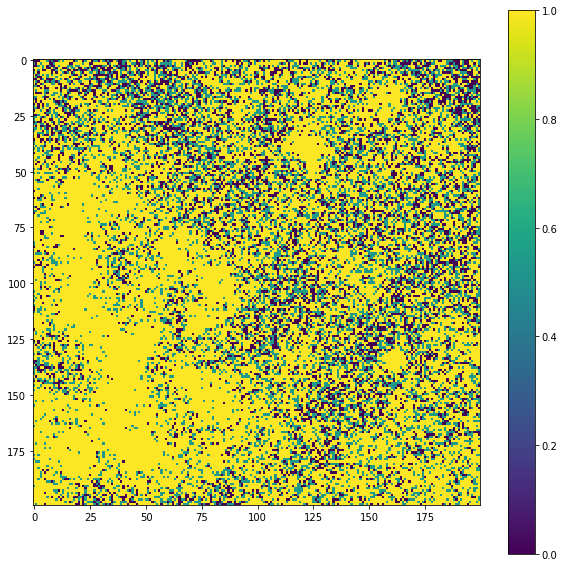

In [20]:
plt.figure(figsize=(10,10))
plt.imshow(data[600:800,600:800,40], vmax=1)
#plt.imshow(data[:,:,50])
plt.colorbar()
plt.show()

In [23]:
np.argmax(gated_image)

210640819

In [24]:
np.unravel_index?

In [25]:
np.unravel_index(210640819, gated_image.shape)

(609, 631, 49)

In [26]:
gated_image[609, 631, 49]

5.293352080625338

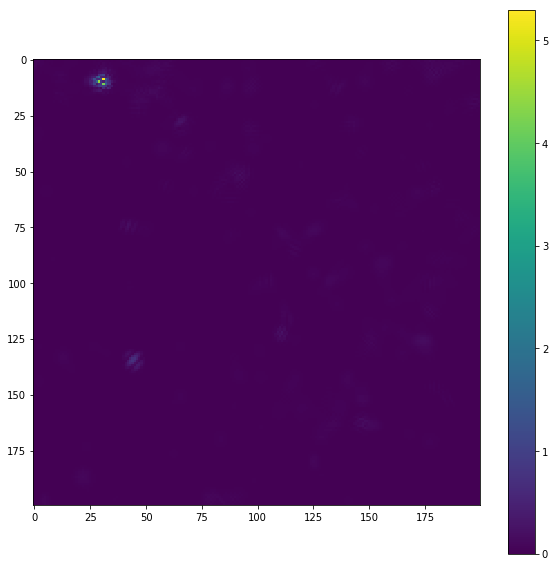

In [28]:
plt.figure(figsize=(10,10))
plt.imshow(gated_image[600:800,600:800,49])
plt.colorbar()
plt.show()

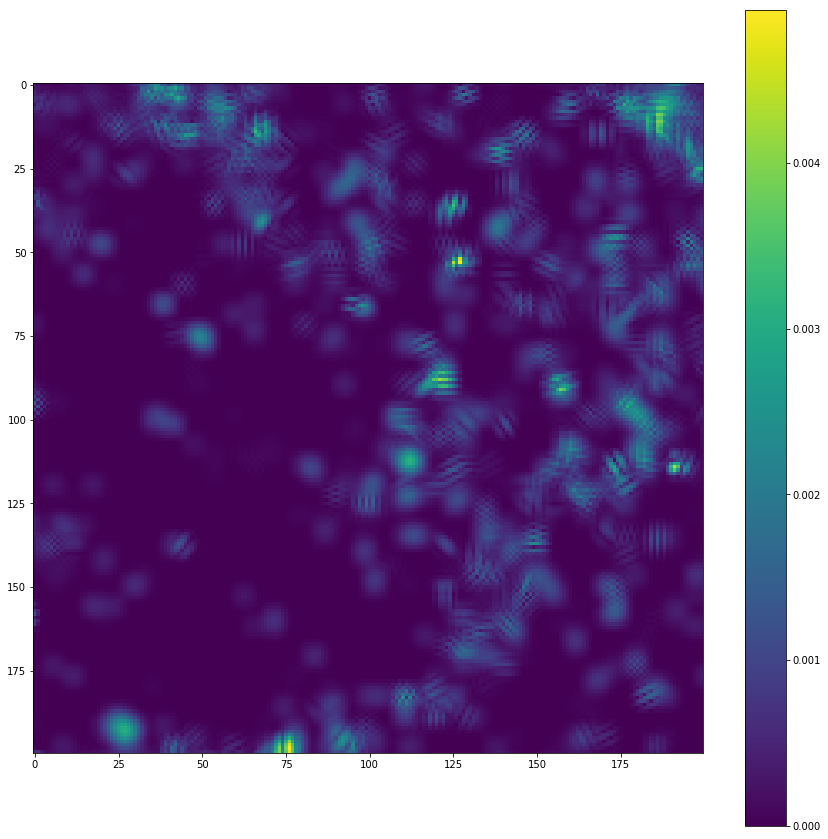

In [42]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,40])
plt.colorbar()
plt.show()

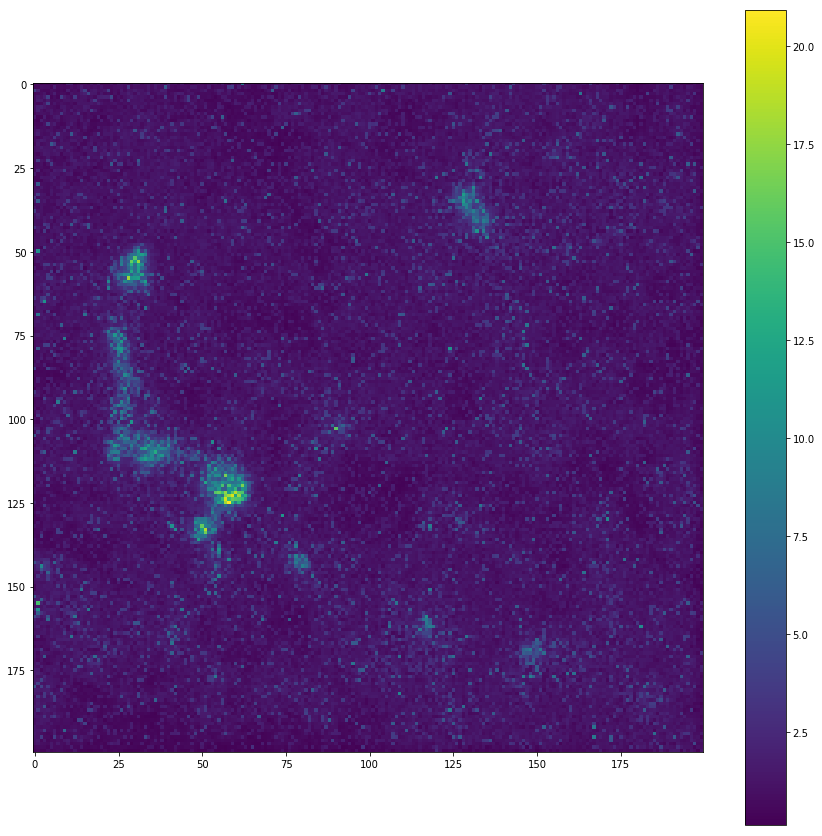

In [234]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,40])
plt.colorbar()
plt.show()

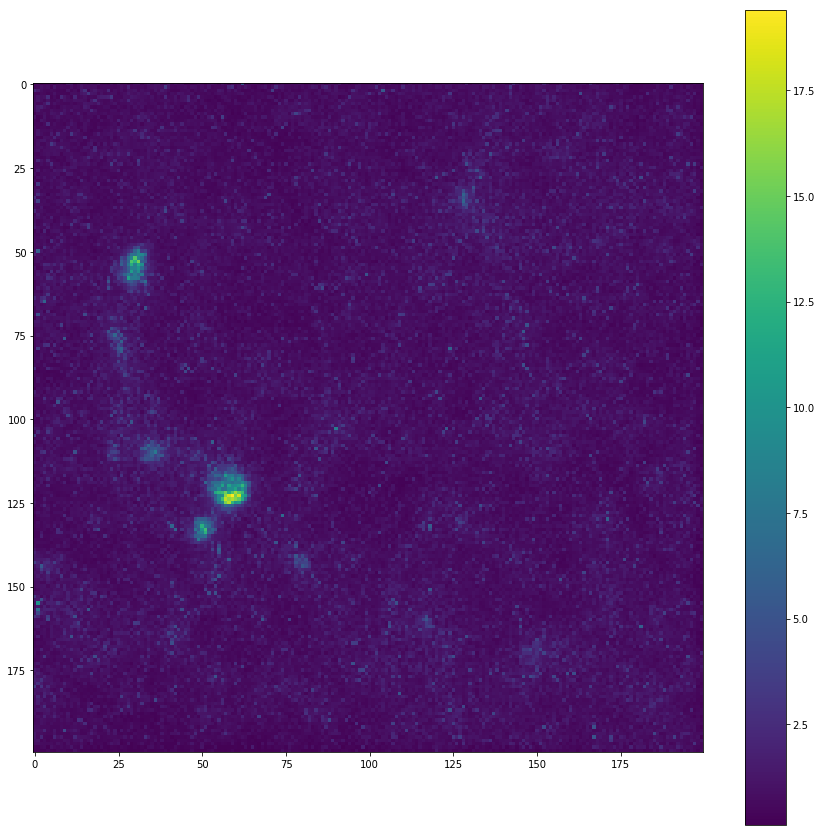

In [231]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,40])
plt.colorbar()
plt.show()

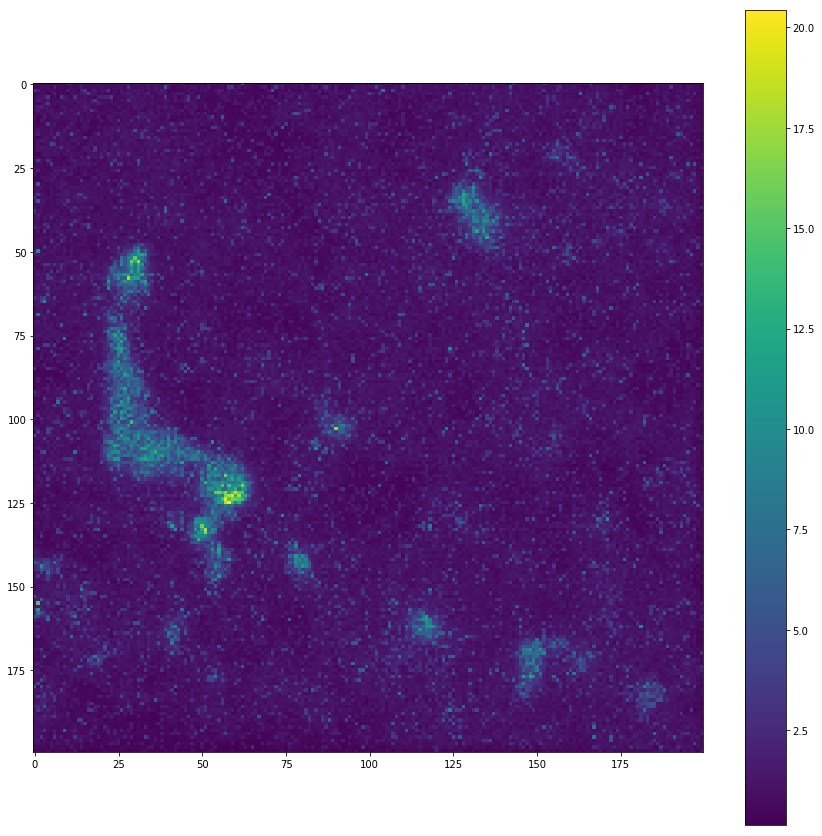

In [227]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,40])
plt.colorbar()
plt.show()

In [94]:
np.median(data[600:800,600:800,12])

0.5760541558265686

In [93]:
np.median(gated_image[600:800,600:800,12])

58.333234287775014

In [92]:
338 / 8

42.25

percentile = 25

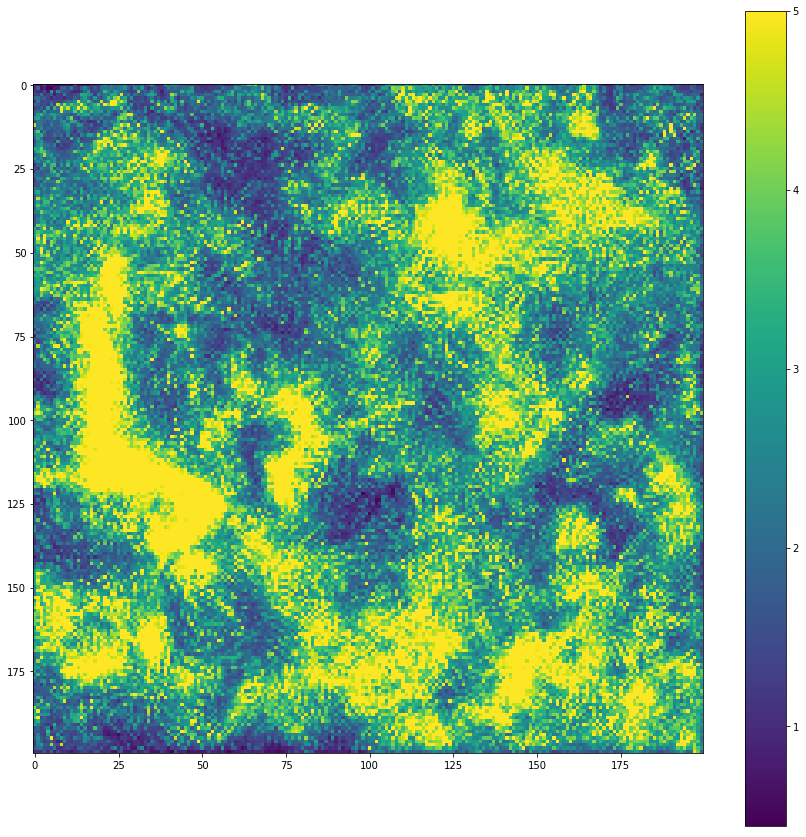

In [52]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,12], vmax=5)
plt.colorbar()
plt.show()

percentile = 45

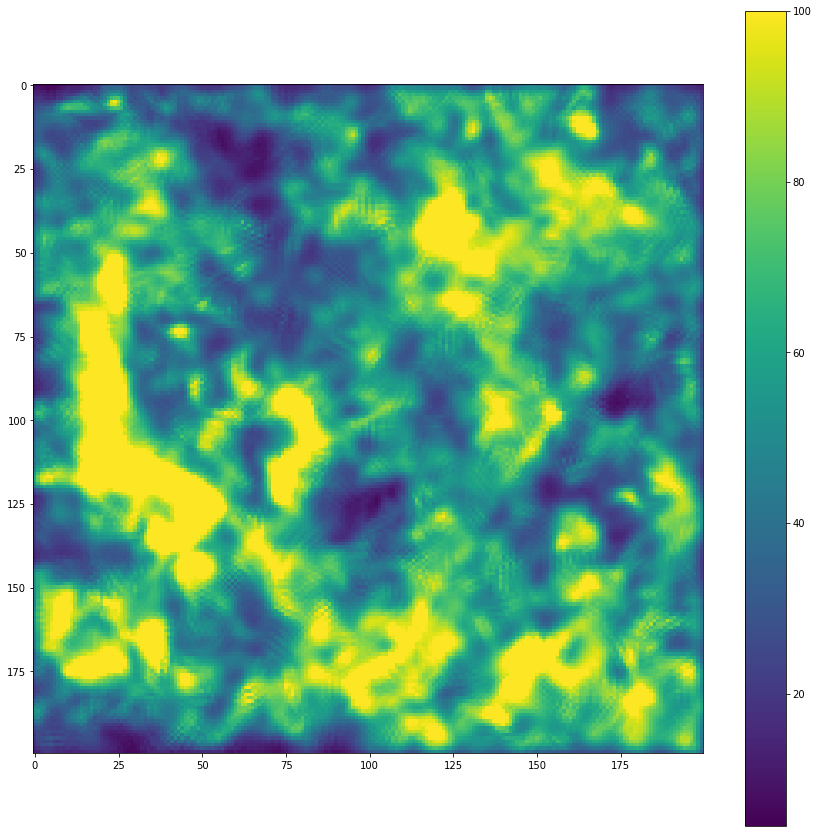

In [88]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,12], vmax=100, interpolation = 'None')
plt.colorbar()
plt.show()

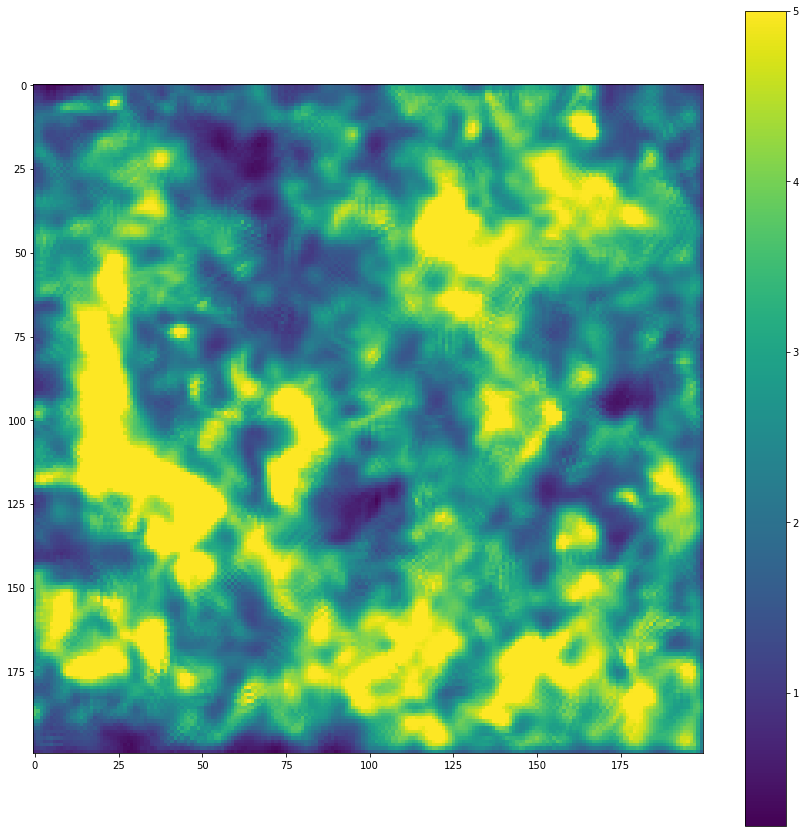

In [77]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,12], vmax=5, interpolation = 'None')
plt.colorbar()
plt.show()

percentile = 50

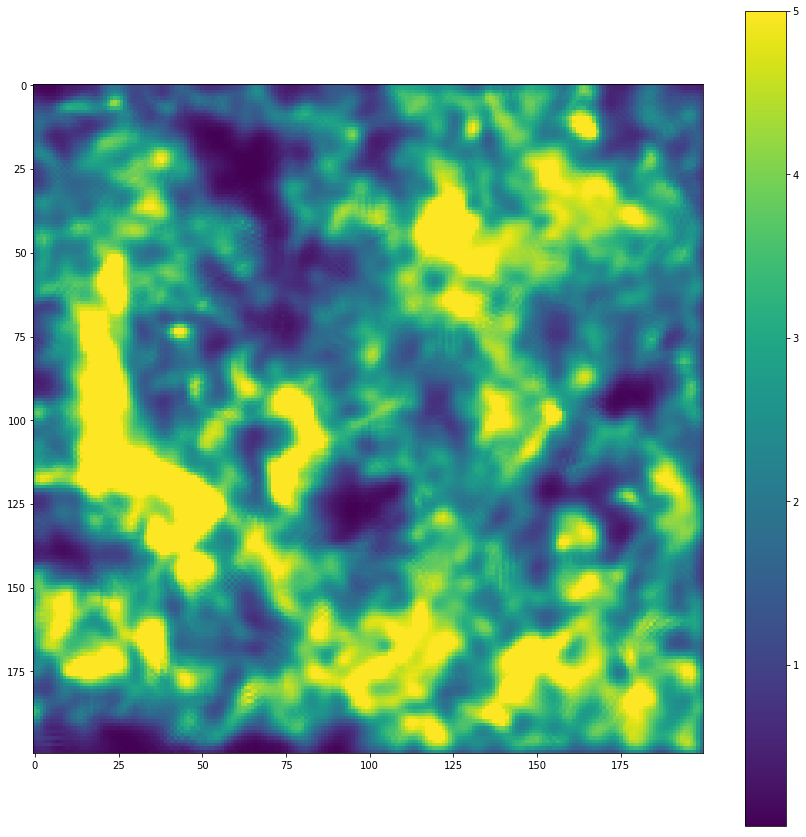

In [68]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,12], vmax=5)
plt.colorbar()
plt.show()

percentile = 55

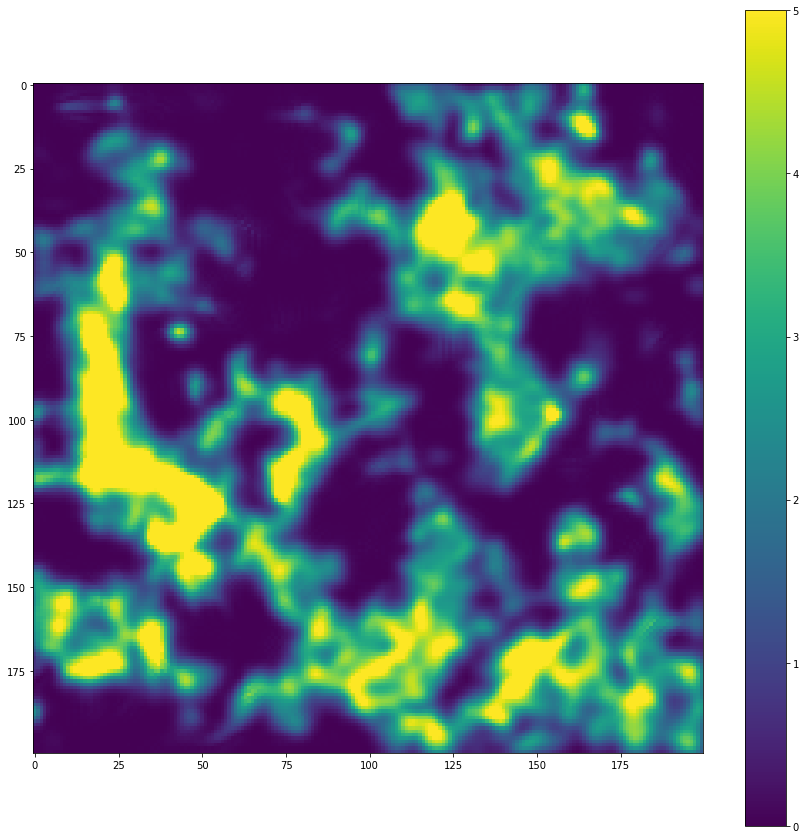

In [65]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,12], vmax=5)
plt.colorbar()
plt.show()

percentile = 60

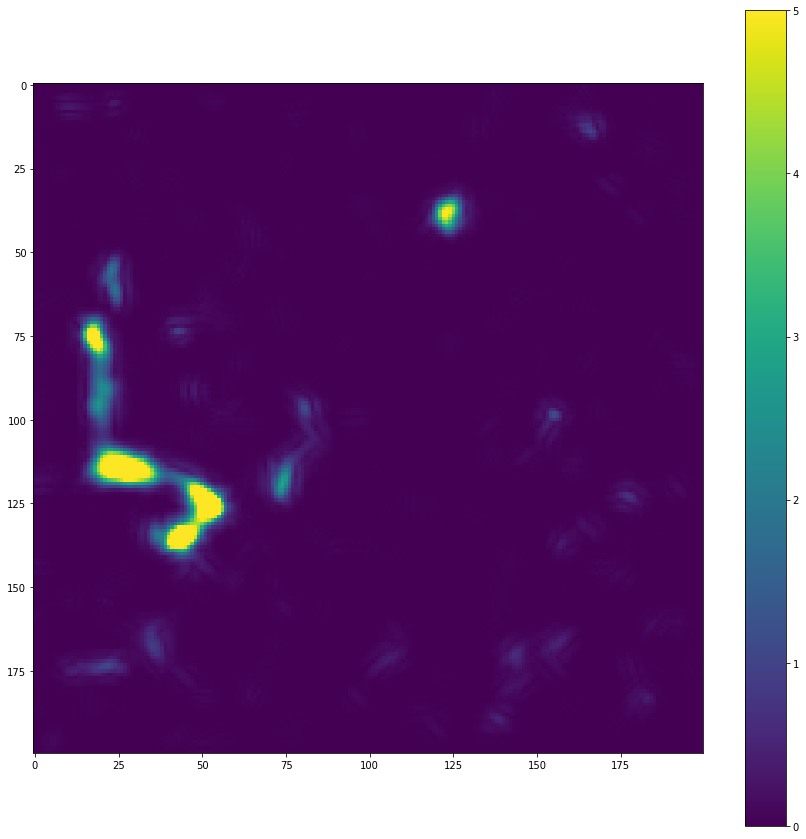

In [61]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,12], vmax=5)
plt.colorbar()
plt.show()

percentinle = 75 

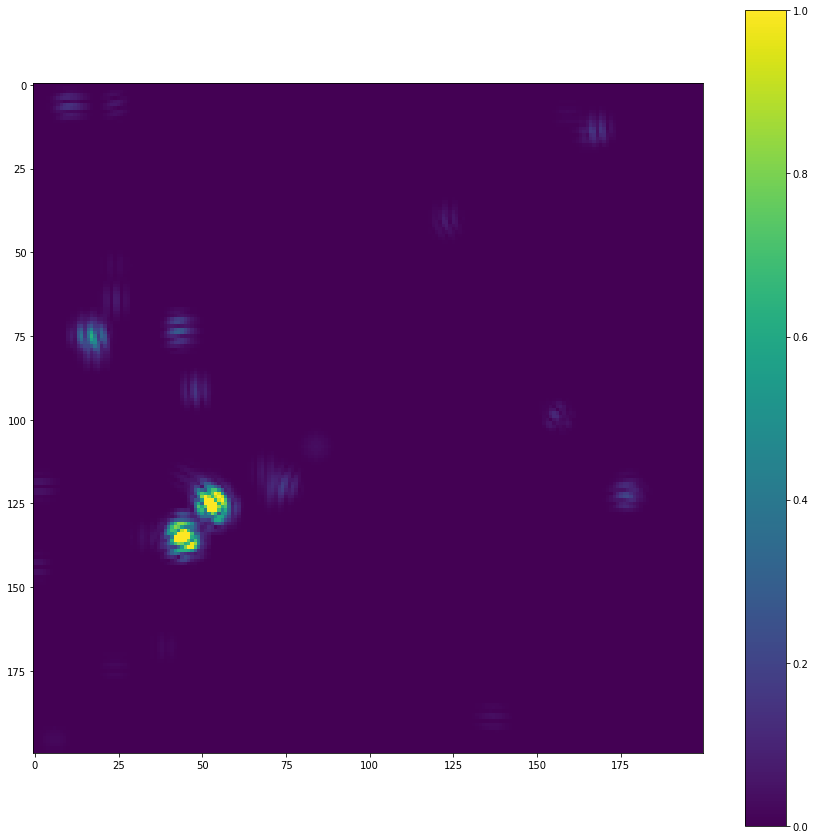

In [57]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,12], vmax=1)
plt.colorbar()
plt.show()

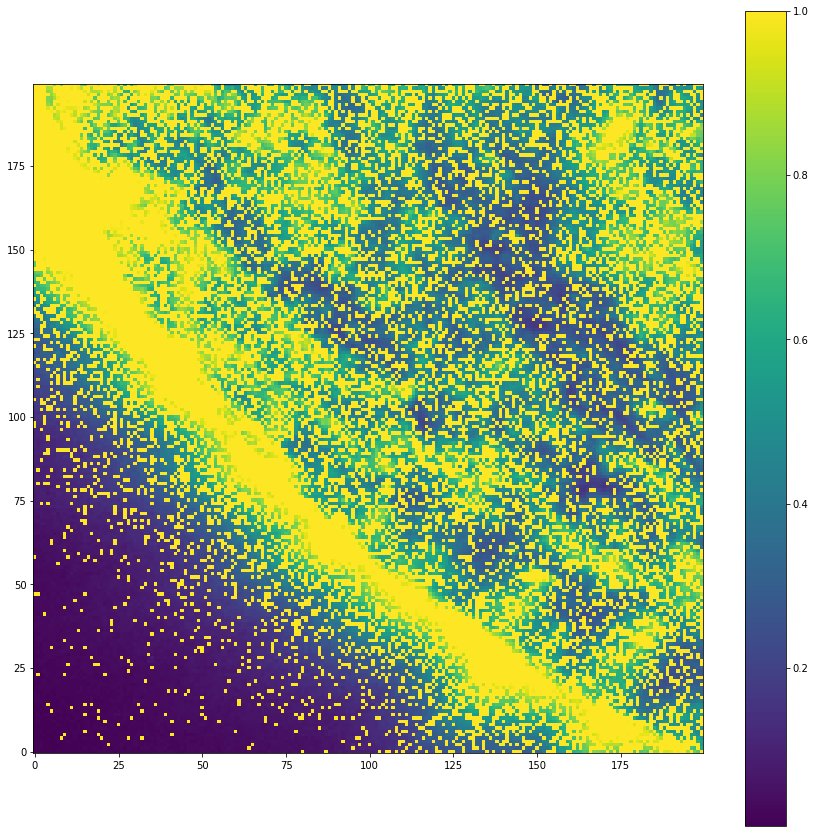

In [30]:
plt.figure(figsize=(15,15))
plt.imshow(data[300:500,300:500,12], vmax=1, interpolation='None', origin='lower')
plt.colorbar()
plt.show()

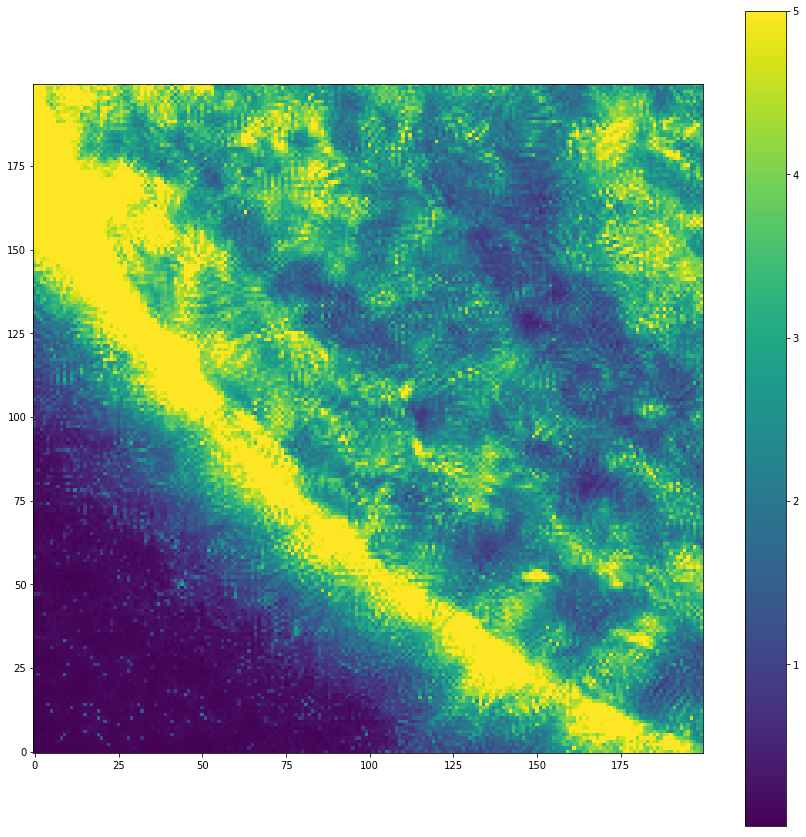

In [29]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[300:500,300:500,12], vmax=5, interpolation='None', origin='lower')
plt.colorbar()
plt.show()

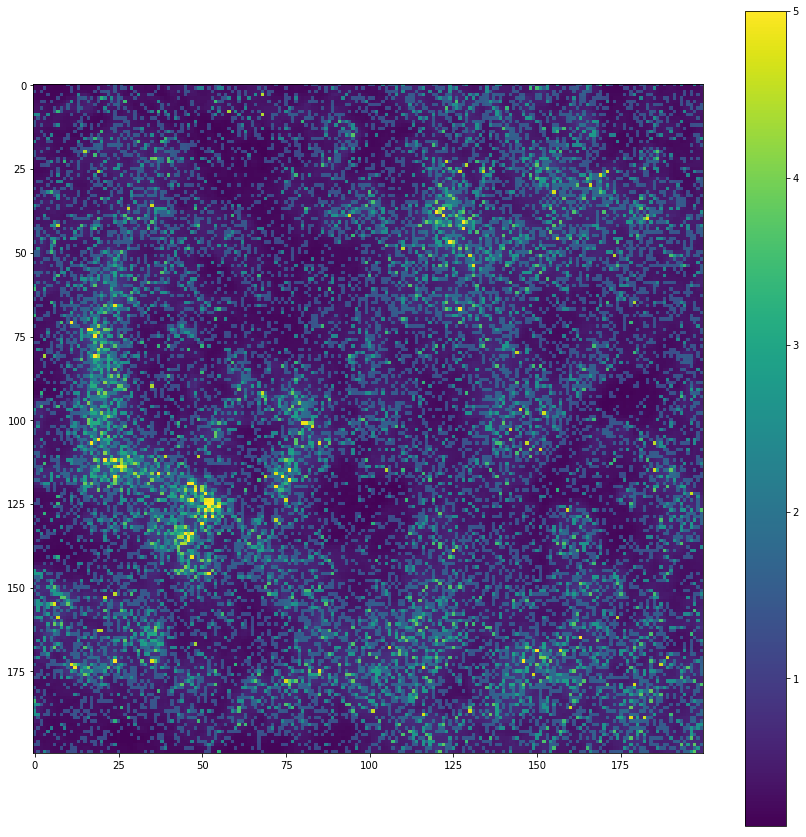

In [199]:
plt.figure(figsize=(15,15))
plt.imshow(data[600:800,600:800,12], vmax=5)
#plt.imshow(data[:,:,50])
plt.colorbar()
plt.show()

gate: Below gamma is 2

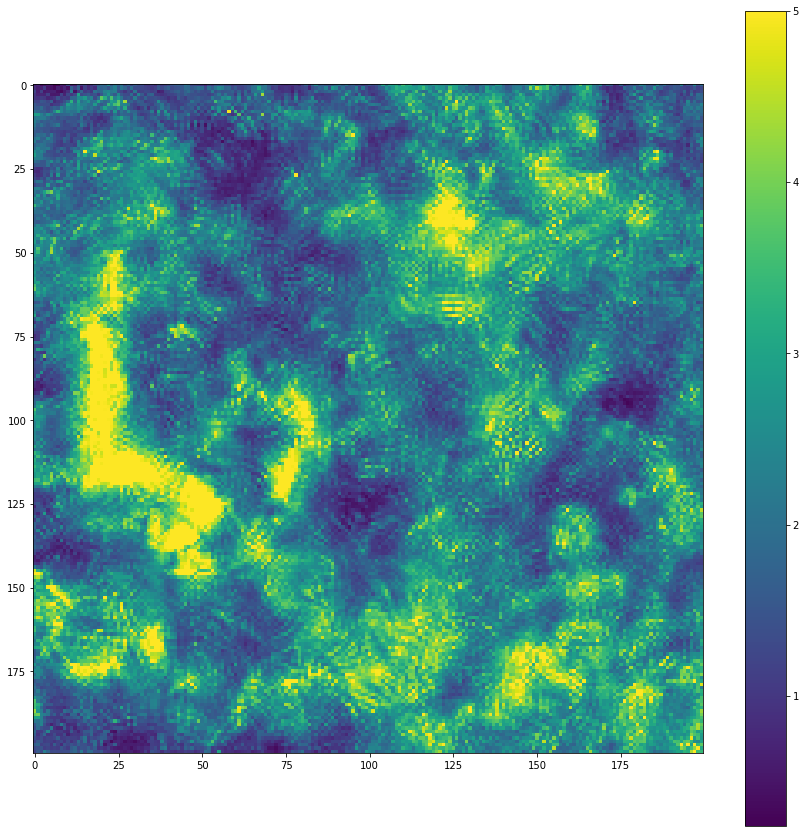

In [186]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,12], vmax=5)
plt.colorbar()
plt.show()

wiener: below gamma is 2

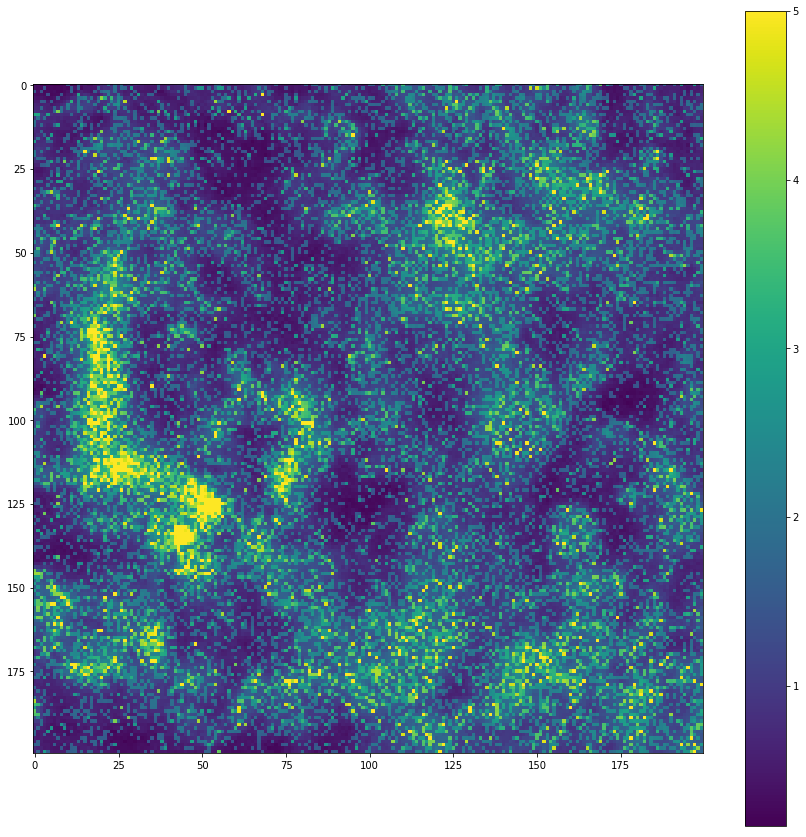

In [188]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,12], vmax=5)
plt.colorbar()
plt.show()

gate: Below gamma is 3

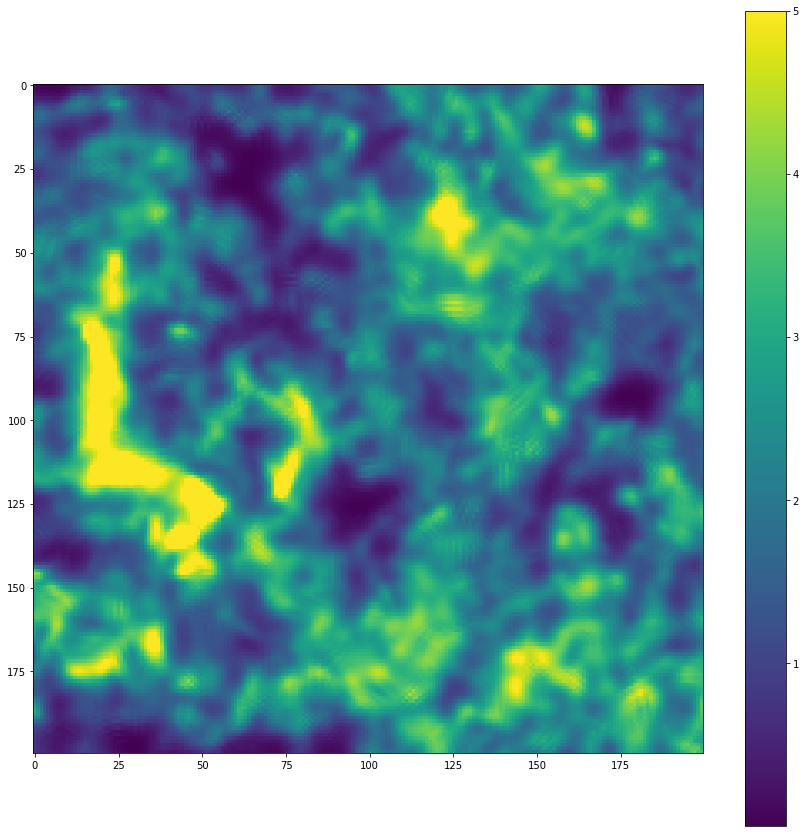

In [184]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,12], vmax=5)
plt.colorbar()
plt.show()

Wiener: below gamma is 3

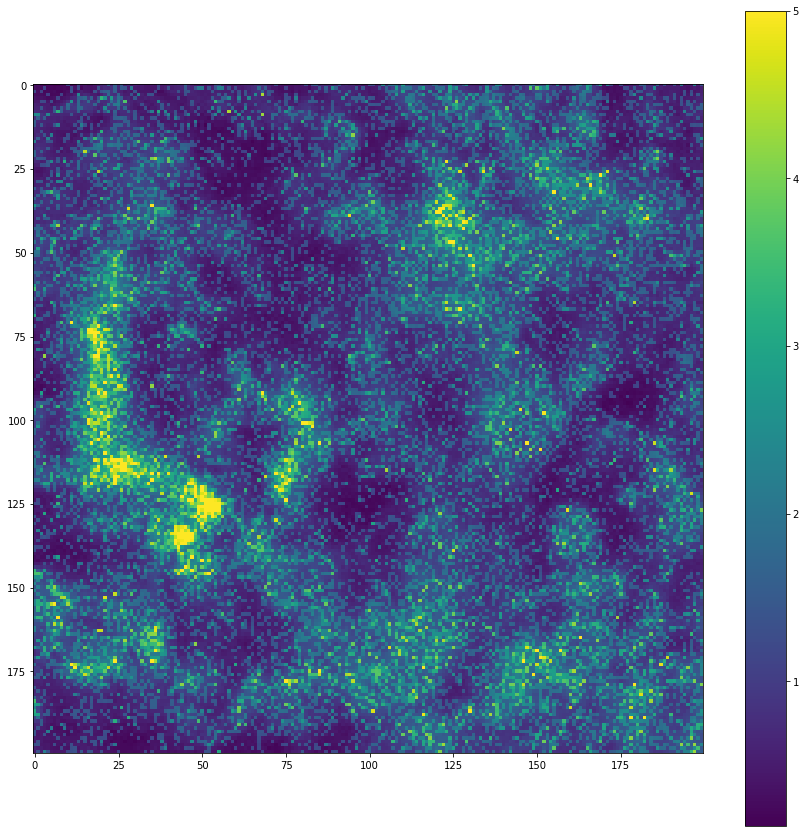

In [190]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,12], vmax=5)
plt.colorbar()
plt.show()

wiener: below gamma is 10

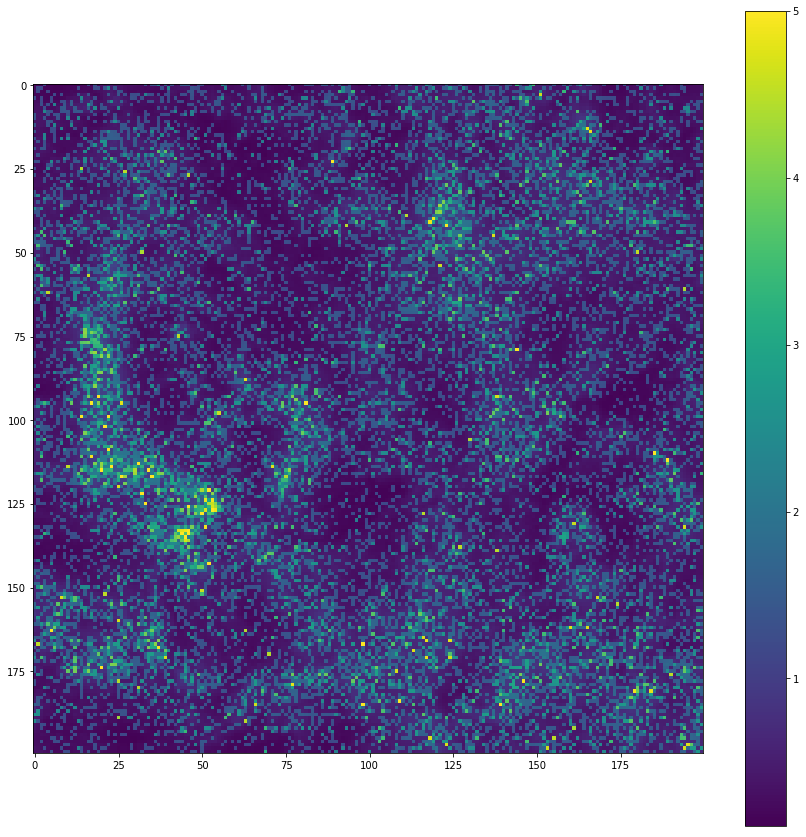

In [235]:
plt.figure(figsize=(15,15))
plt.imshow(data[600:800,600:800,12], vmax=5)
#plt.imshow(data[:,:,50])
plt.colorbar()
plt.show()

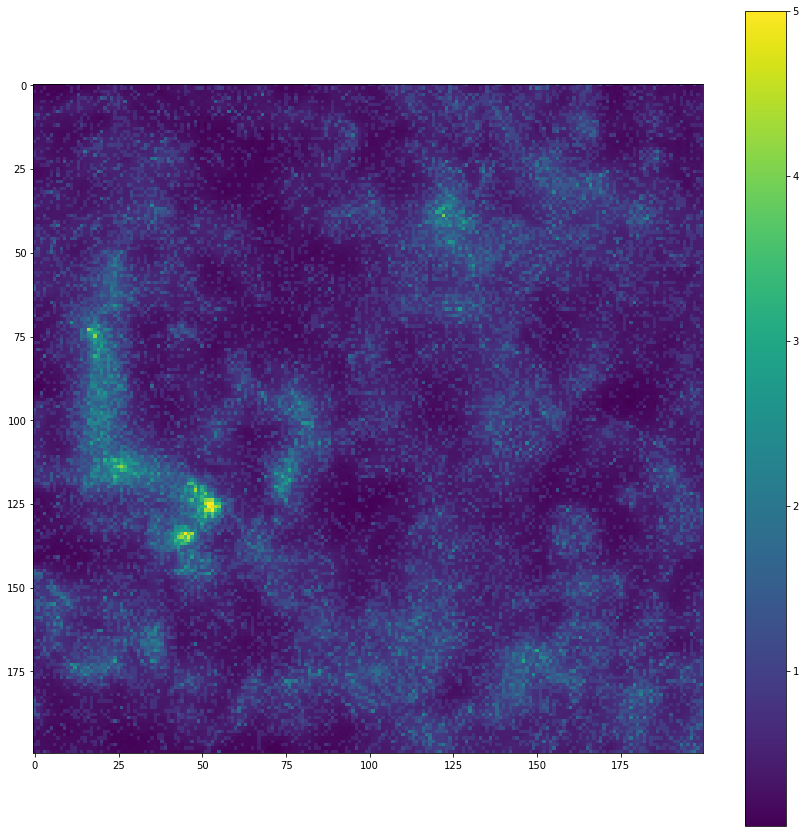

In [195]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,12], vmax=5)
plt.colorbar()
plt.show()

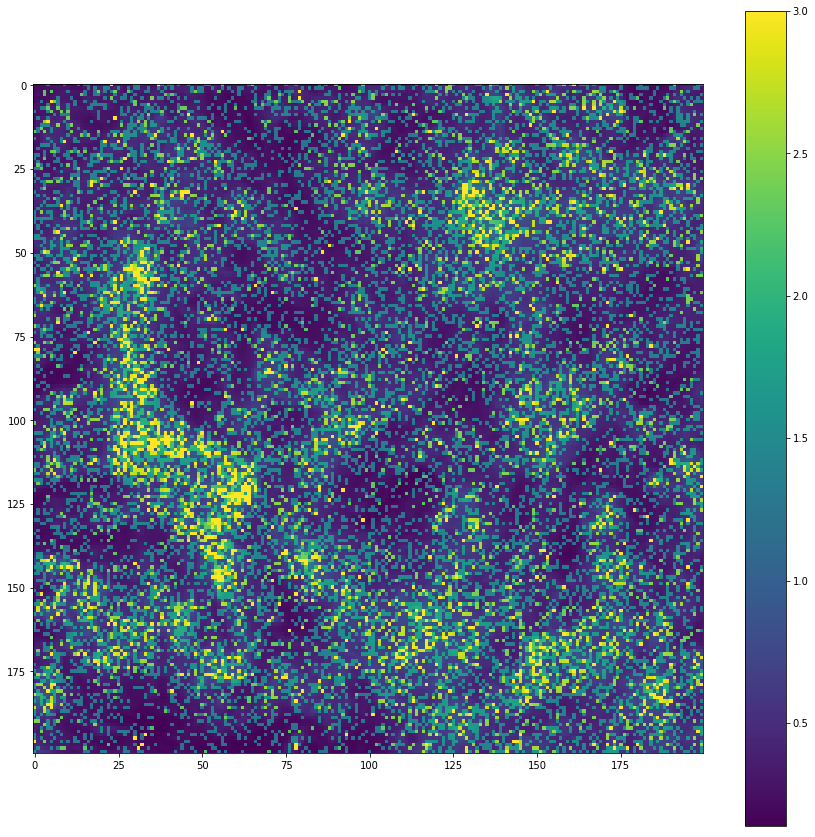

In [59]:
plt.figure(figsize=(15,15))
plt.imshow(data[600:800,600:800,50], vmax=3)
#plt.imshow(data[:,:,50])
plt.colorbar()
plt.show()

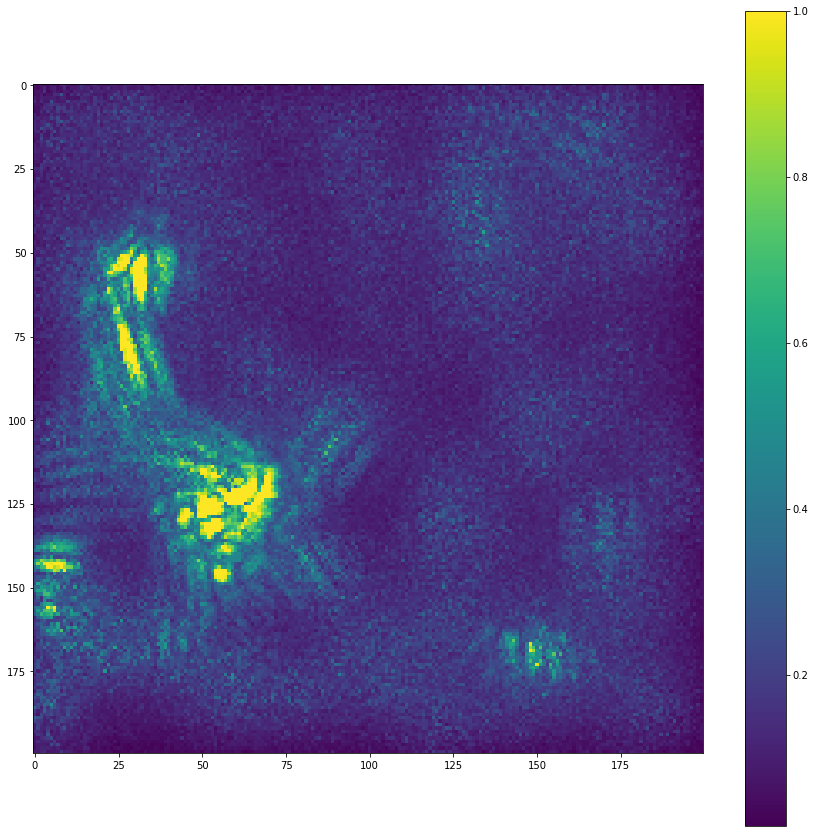

In [60]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,50], vmax=1)
plt.colorbar()
plt.show()

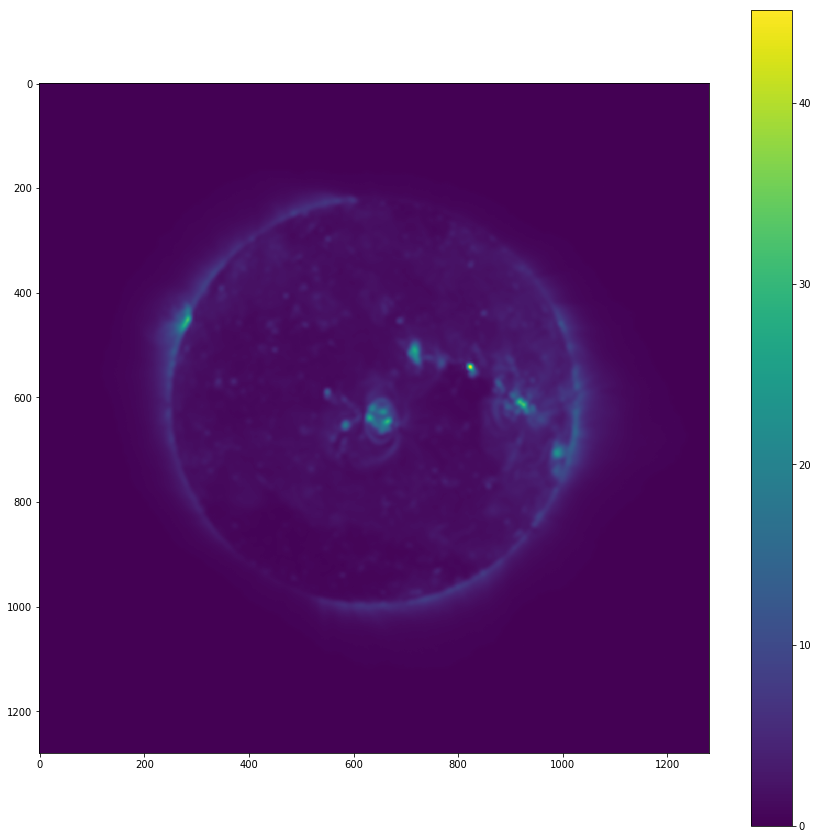

In [51]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[:,:,50])
plt.colorbar()
plt.show()

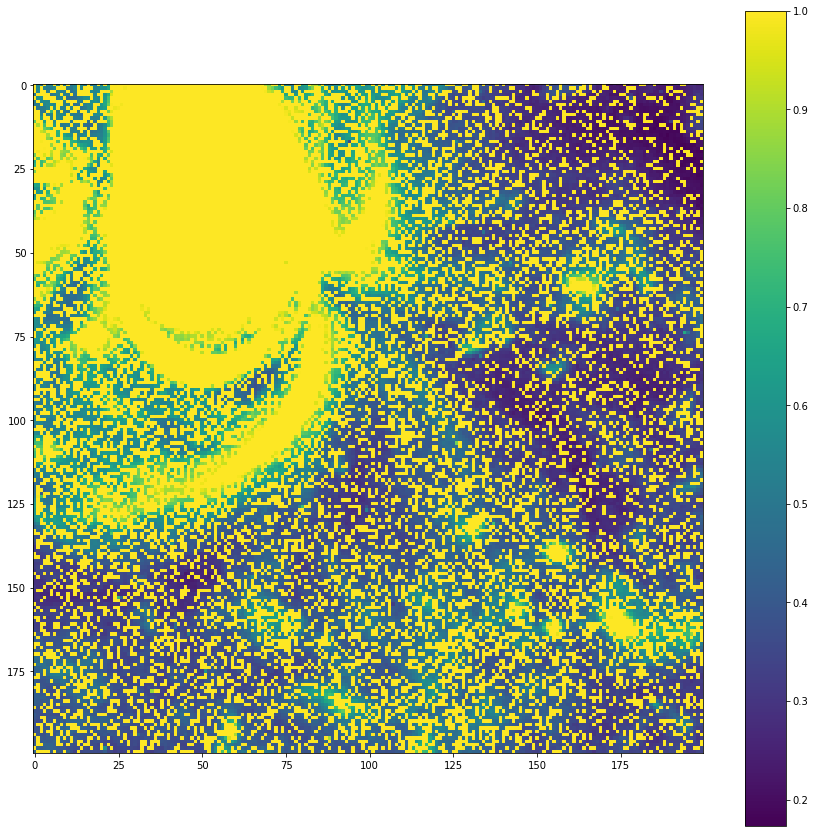

In [13]:
plt.figure(figsize=(15,15))
plt.imshow(data[600:800,600:800,50], vmax=1)
#plt.imshow(data[:,:,50])
plt.colorbar()
plt.show()

Below is with a gate filter

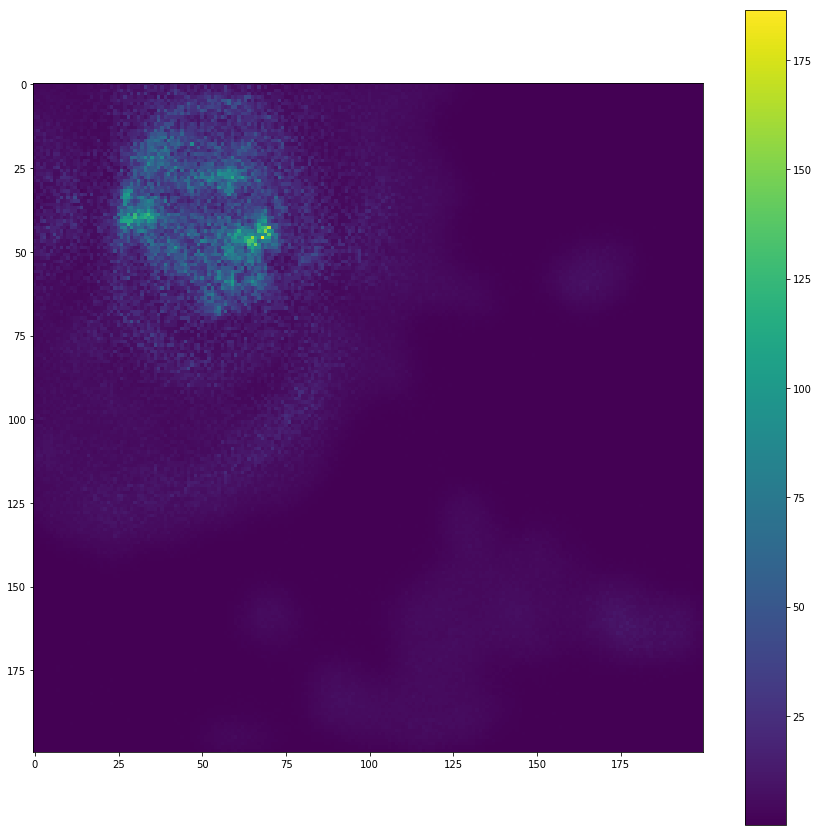

In [24]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,50])
plt.colorbar()
plt.show()

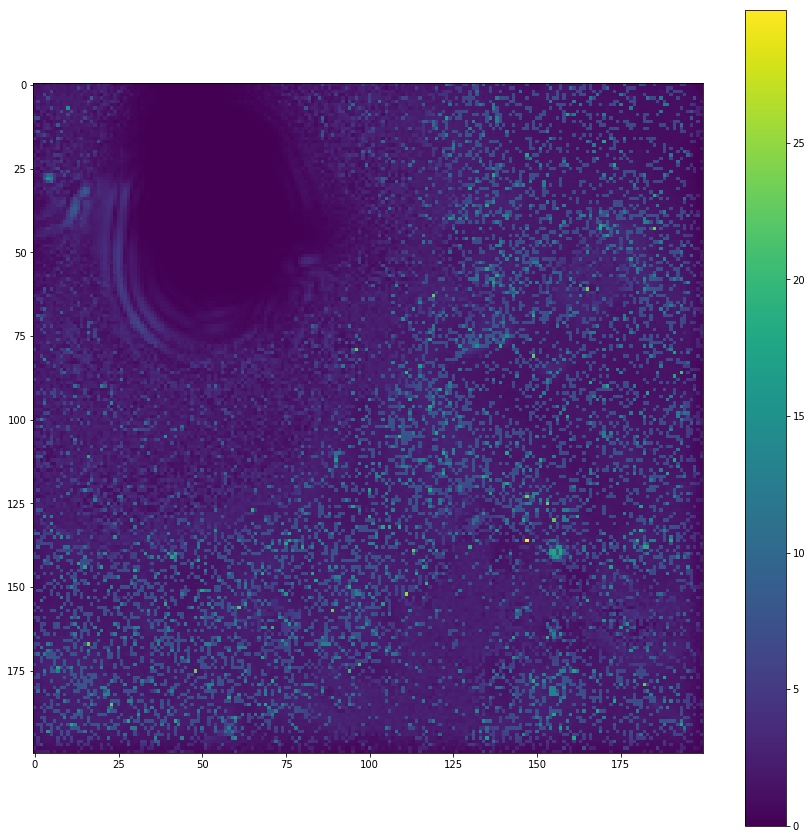

In [19]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,50])
plt.colorbar()
plt.show()

Below is with a wiener filter

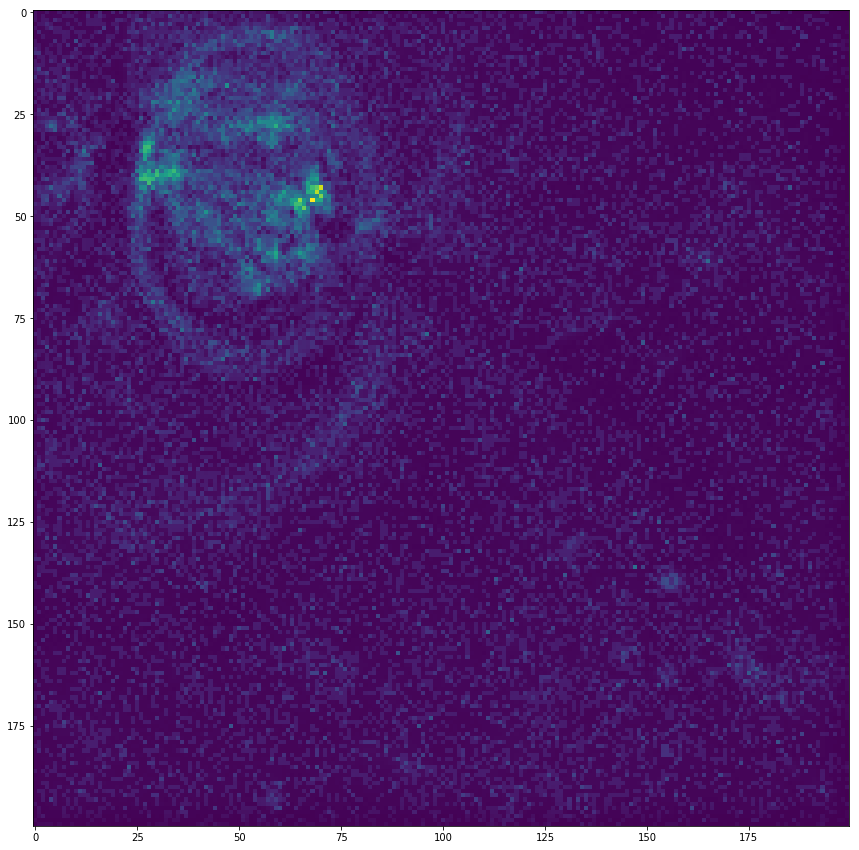

In [14]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,50])
plt.show()